In [1]:
# libraries used
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

In [2]:
# importing the dataset

data = pd.read_csv('ensembleMean_merged.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [3]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00'] # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00'] # testing set are data from dates after 2018

In [4]:
# splitting the sets into variables and response
y_train = train['response'].values
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]].values

y_test = test['response'].values
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]].values

In [5]:
# Splitting indices to create a custom cv (in order to tune the hyper-parameters)

train_indices = list(range(0,5844))             # dates before 2017 to train
test_indices = list(range(5844, len(train)))    # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

### Defining Metric Matrix

With the intention of visualization of the different results of metrics per model, we create a matrix that displays all the results of each model per each data set that we modify. 

Also, it is necessary to create a function that automatically does the imputation in the matrix for us. 

The function made requires 5 arguments: the true reponse (y element) for training set and testing set; the prediction of the response that the different models have made and the name of the model. 

In [6]:
# creating a metrics matrix in order to visualize the results of different methods
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['RF_all','GB_all','SVM_all',
                                'RF_uv','GB_uv','SVM_uv',
                                'RF_module','GB_module','SVM_module'])

In [7]:
# Metrics matrix for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

In [8]:
# Pipelines for RF which contains the procedure of scaling, dimension reduction and modeling
pipe_rf = Pipeline([('scale',StandardScaler()),
                    ('dim_red', PCA(random_state=10)),
                    ('model',RandomForestRegressor(random_state = 10))
                   ])

In [9]:
# Pipelines for GB
pipe_gb = Pipeline([('scale',StandardScaler()),
                    ('dim_red', PCA(random_state=10)),
                    ('model',GradientBoostingRegressor(random_state = 10))
                   ])

In [10]:
# Pipelines for SVM
pipe_svm = Pipeline([('scale',StandardScaler()),
                    ('dim_red', PCA(random_state=10)),
                    ('model',SVR())
                   ])

### ALL VARIABLES

#### 1. Random forest

For the pipeline of random forest, we will be tuning 4 different hyperparameters: 

**hyperparameter of PCA:** 
- n_components, it indicates the % of variance that the PCA will explain; 

**hyperparameters of RF:**
- max_depth, hype which is the maximum number of levels in each decision tree;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node;
- n_estimators which is the number of trees in the forests.

In this case, number of features will not be tuned as we will have very little variables after using PCA. 

In [11]:
params_rf1 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(3, 15),
              'model__n_estimators': sp_randint(150, 300)}
                    
                    
rf_search1 = RandomizedSearchCV(pipe_rf, params_rf1, cv=custom_cv, random_state = 10)
rf1 = rf_search1.fit(x_train, y_train).best_estimator_

In [12]:
rf1

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=4,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=181, n_jobs=None,
                    

**The best hyperparameters are as follows:**

In [13]:
rf_search1.best_params_

{'dim_red__n_components': 0.9,
 'model__max_depth': 4,
 'model__min_samples_leaf': 4,
 'model__n_estimators': 181}

In [14]:
rf1_pred_train = rf1.predict(x_train)
rf1_pred_test = rf1.predict(x_test)

In [15]:
metrics(y_train, rf1_pred_train, y_test, rf1_pred_test, 'RF_all')

explained variance of training set: 0.8843528734495771
explained variance of testing set: 0.8402235802017463
maximum error of training set: 1900.3867564373286
maximum error of testing set: 1971.039895524822
mae of training set: 252.48949746486568
mae of testing set: 263.2467626171579
mse of training set: 117445.9988720269
mse of testing set: 134965.88214707747
rmse of training set: 342.70395222703064
rmse of testing set: 367.3770299665964


#### 2 Gradient Boosting

For the pipeline of gradient boosting, we tune 5 different hyperparameters: 

**hyperparameter of PCA:** 

- n_components, it indicates the % of variance that the PCA will explain; 


**hyperparameters of GB:** 
- learning_rate determines the weight of each tree added to the global model;
- n_estimators which is the number of trees in the forest;
- max_depth which is the maximum number of levels in each decision tree;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node;

In [16]:
params_gb1 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__learning_rate': loguniform(0.0001, 0.4),
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(5, 15),
              'model__n_estimators': sp_randint(150, 300)}
                    
                    
gb_search1 = RandomizedSearchCV(pipe_gb, params_gb1, cv=custom_cv, random_state = 10)
gb1 = gb_search1.fit(x_train, y_train).best_estimator_

In [17]:
gb1

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.09921894902812727,
                                           loss='ls', max_depth=4,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=5,
                        

**The best parameters are as follows:**

In [18]:
gb_search1.best_params_

{'dim_red__n_components': 0.95,
 'model__learning_rate': 0.09921894902812727,
 'model__max_depth': 4,
 'model__min_samples_leaf': 5,
 'model__n_estimators': 263}

In [19]:
gb1_pred_train = gb1.predict(x_train)
gb1_pred_test = gb1.predict(x_test)

In [20]:
metrics(y_train, gb1_pred_train, y_test, gb1_pred_test, 'GB_all')

explained variance of training set: 0.9530940450423235
explained variance of testing set: 0.8904151932079343
maximum error of training set: 1541.039234323196
maximum error of testing set: 1993.7927704111185
mae of training set: 154.1044636870077
mae of testing set: 206.18166552180168
mse of training set: 47635.56895111151
mse of testing set: 92639.72719731637
rmse of training set: 218.25574208050406
rmse of testing set: 304.3677499297788


#### 1.3 Support Vector Machine

For pipeline of SVM, we tune 3 different hyperparameters: 

**hyperparameter of PCA:** 

- n_components, it indicates the % of variance that the PCA will explain; 


**hyperparameters of SVM:** 
- C, C parameter adds a penalty for each misclassified data point.
- gamma, gamma parameter of RBF controls the distance of influence of a single training point

In [21]:
params_svm1 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__C': loguniform(10e-6, 10e+6),
              'model__gamma': loguniform(10e-6, 10e+1),
              'model__kernel': ['rbf']}
                    
                    
svm_search1 = RandomizedSearchCV(pipe_svm, params_svm1, cv=custom_cv, random_state = 10)
svm1 = svm_search1.fit(x_train, y_train).best_estimator_

In [22]:
svm1

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.7,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVR(C=1229.1457413949752, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=0.01238318100233795, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

**The best hyperparameters for SVM model are as follows:**

In [23]:
svm_search1.best_params_

{'dim_red__n_components': 0.7,
 'model__C': 1229.1457413949752,
 'model__gamma': 0.01238318100233795,
 'model__kernel': 'rbf'}

In [24]:
svm1_pred_train = svm1.predict(x_train)
svm1_pred_test = svm1.predict(x_test)

In [25]:
metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM_all')

explained variance of training set: 0.9030749957281853
explained variance of testing set: 0.8727051849812987
maximum error of training set: 2242.1404678461777
maximum error of testing set: 1870.867883168351
mae of training set: 212.12916599268334
mae of testing set: 220.75014993397124
mse of training set: 98669.902323572
mse of testing set: 107580.43695933276
rmse of training set: 314.11765681599627
rmse of testing set: 327.99456849059675


### U, V COMPONENT

In [26]:
# create a new data set that does not contain the module variable

data_u_v = data[data.columns.drop(list(data.filter(regex='norma')))]

In [27]:
# checking the shape is correct
# 98-24=74, we had 98 variables before (INCLUDING TIME AND RESPONSE), 
# we have 24 variables of module (12 coordinates for uv10 and 12 coordinates for uv100)
data_u_v.shape 

(11682, 74)

In [28]:
# splitting the data set into training set and testing set 
train_uv = data_u_v[data_u_v['time']<'2018-01-01 00:00:00']
test_uv = data_u_v[data_u_v['time']>='2018-01-01 00:00:00']

y_train_uv = train_uv['response'].values
x_train_uv = train_uv[[x for x in train_uv.columns if (x != 'response') & (x != 'time')]].values

y_test_uv = test_uv['response'].values
x_test_uv = test_uv[[x for x in test_uv.columns if (x != 'response') & (x != 'time')]].values

#### 1 Random Forest

In [29]:
params_rf2 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(5, 15),
              'model__n_estimators': sp_randint(150, 300)}
                    
                    
rf_search2 = RandomizedSearchCV(pipe_rf, params_rf2, cv=custom_cv, random_state = 10)
rf2 = rf_search2.fit(x_train_uv, y_train_uv).best_estimator_

In [30]:
rf2

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=4,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=204, n_jobs=None,
                    

**The best hyper-parameters are: **

In [31]:
rf_search2.best_params_

{'dim_red__n_components': 0.9,
 'model__max_depth': 4,
 'model__min_samples_leaf': 8,
 'model__n_estimators': 204}

In [32]:
rf2_pred_train = rf2.predict(x_train_uv)
rf2_pred_test = rf2.predict(x_test_uv)

In [33]:
metrics(y_train_uv, rf2_pred_train, y_test_uv, rf2_pred_test, 'RF_uv')

explained variance of training set: 0.8190000381188843
explained variance of testing set: 0.729783288576133
maximum error of training set: 2231.128694193735
maximum error of testing set: 2488.3636008176363
mae of training set: 321.33855529038965
mae of testing set: 350.7449653616777
mse of training set: 183815.4948858921
mse of testing set: 228825.95548424777
rmse of training set: 428.7370929671144
rmse of testing set: 478.3575602875403


#### 2.2 Gradient Boosting

In [34]:
params_gb2 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__learning_rate': loguniform(0.0001, 0.4),
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(5, 15),
              'model__n_estimators': sp_randint(150, 300)}
                    
                    
gb_search2 = RandomizedSearchCV(pipe_gb, params_gb2, cv=custom_cv, random_state = 10)
gb2 = gb_search2.fit(x_train_uv, y_train_uv).best_estimator_

In [35]:
gb2

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.09921894902812727,
                                           loss='ls', max_depth=4,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=5,
                        

**The best hyper-parameters are:**

In [36]:
gb_search2.best_params_

{'dim_red__n_components': 0.95,
 'model__learning_rate': 0.09921894902812727,
 'model__max_depth': 4,
 'model__min_samples_leaf': 5,
 'model__n_estimators': 263}

In [37]:
gb2_pred_train = gb2.predict(x_train_uv)
gb2_pred_test = gb2.predict(x_test_uv)

In [38]:
metrics(y_train_uv, gb2_pred_train, y_test_uv, gb2_pred_test, 'GB_uv')

explained variance of training set: 0.9354592953749581
explained variance of testing set: 0.8648562575520935
maximum error of training set: 1722.6454652864245
maximum error of testing set: 2023.2900661878357
mae of training set: 181.18738941691896
mae of testing set: 232.51530193274394
mse of training set: 65544.62409077029
mse of testing set: 114155.58556246414
rmse of training set: 256.0168433731857
rmse of testing set: 337.86918409713564


#### 2.3Support Vector Machines

In [39]:
params_svm2 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__C': loguniform(10e-6, 10e+6),
              'model__gamma': loguniform(10e-6, 10e+1),
              'model__kernel': ['rbf']}
                    
                    
svm_search2 = RandomizedSearchCV(pipe_svm, params_svm2, cv=custom_cv, random_state = 10)
svm2 = svm_search2.fit(x_train_uv, y_train_uv).best_estimator_

In [40]:
svm2

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.7,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVR(C=1229.1457413949752, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=0.01238318100233795, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

**The best hyper-parameters are:**

In [41]:
svm_search2.best_params_

{'dim_red__n_components': 0.7,
 'model__C': 1229.1457413949752,
 'model__gamma': 0.01238318100233795,
 'model__kernel': 'rbf'}

In [42]:
svm2_pred_train = svm2.predict(x_train_uv)
svm2_pred_test = svm2.predict(x_test_uv)

In [43]:
metrics(y_train_uv, svm2_pred_train, y_test_uv, svm2_pred_test, 'SVM_uv')

explained variance of training set: 0.8925541241562582
explained variance of testing set: 0.8540884025120231
maximum error of training set: 1921.0929518250737
maximum error of testing set: 2176.8661719155507
mae of training set: 228.83028553572376
mae of testing set: 240.45392502968332
mse of training set: 109663.23382717192
mse of testing set: 123262.2781722208
rmse of training set: 331.1543957539624
rmse of testing set: 351.08727999205666


### 3. ONLY MODULE

Finally, we train the models using only the modules instead of u,v components. Now we will only have 48 variables (48 variables of u,v components: 12 coordinates for u,v 10 and 100).

In [44]:
# creating data set that does not contain u,v components
data_module = data[data.columns.drop(list(data.filter(regex='u100')))]
data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='v100')))]

data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='u10')))]
data_module = data_module[data_module.columns.drop(list(data_module.filter(regex='v10')))]

In [45]:
# splitting the data set into training set and testing set 
train_module = data_module[data_module['time']<'2018-01-01 00:00:00']
test_module = data_module[data_module['time']>='2018-01-01 00:00:00']


y_train_module = train_module['response'].values
x_train_module = train_module[[x for x in train_module.columns if (x != 'response') & (x != 'time')]].values

y_test_module = test_module['response'].values
x_test_module = test_module[[x for x in test_module.columns if (x != 'response') & (x != 'time')]].values

In [46]:
data_module.shape # 50 variables including TIME and RESPONSE

(11682, 50)

#### 3.1 Random Forest

In [47]:
params_rf3 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(5, 20),
              'model__n_estimators': sp_randint(150, 300)}
                    
                    
rf_search3 = RandomizedSearchCV(pipe_rf, params_rf3, cv=custom_cv, random_state = 10)
rf3 = rf_search3.fit(x_train_module, y_train_module).best_estimator_

In [48]:
rf3

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=4,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=17, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=215, n_jobs=None,
                   

**The best hyper-parameters are:**

In [49]:
rf_search3.best_params_

{'dim_red__n_components': 0.9,
 'model__max_depth': 4,
 'model__min_samples_leaf': 17,
 'model__n_estimators': 215}

In [50]:
rf3_pred_train = rf3.predict(x_train_module)
rf3_pred_test = rf3.predict(x_test_module)

Training by random forest using module instead of u v components, we got the following conclusions:
- The explained variance of testing set of almost 85%; the rooted mean square error is 351, it has the worst results among all. It is a better idea to train the model using all the variables related to the u,v components. 

In [51]:
metrics(y_train_module, rf3_pred_train, y_test_module, rf3_pred_test, 'RF_module')

explained variance of training set: 0.7690804226356993
explained variance of testing set: 0.7236232270052341
maximum error of training set: 2622.7219604602524
maximum error of testing set: 2110.996617539934
mae of training set: 354.5877798832852
mae of testing set: 357.19874621420325
mse of training set: 234512.06540762534
mse of testing set: 235705.03309238027
rmse of training set: 484.2644581296725
rmse of testing set: 485.4946272538763


#### 3.2 Gradient Boosting

In [52]:
params_gb3 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__learning_rate': loguniform(0.0001, 0.4),
              'model__max_depth': sp_randint(3, 5), 
              'model__min_samples_leaf': sp_randint(5, 20),
              'model__n_estimators': sp_randint(150, 300)}
                    
                    
gb_search3 = RandomizedSearchCV(pipe_gb, params_gb3, cv=custom_cv, random_state = 10)
gb3 = gb_search3.fit(x_train_module, y_train_module).best_estimator_

In [53]:
gb3

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.09921894902812727,
                                           loss='ls', max_depth=4,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=5,
                        

**The best hyper-parameters are:**

In [54]:
gb_search3.best_params_

{'dim_red__n_components': 0.95,
 'model__learning_rate': 0.09921894902812727,
 'model__max_depth': 4,
 'model__min_samples_leaf': 5,
 'model__n_estimators': 263}

In [55]:
gb3_pred_train = gb3.predict(x_train_module)
gb3_pred_test = gb3.predict(x_test_module)

In [56]:
metrics(y_train_module, gb3_pred_train, y_test_module, gb3_pred_test, 'GB_module')

explained variance of training set: 0.8943385925000465
explained variance of testing set: 0.8086575780059235
maximum error of training set: 2067.303492682558
maximum error of testing set: 2081.7809381050192
mae of training set: 227.1065682020996
mae of testing set: 283.75503113326846
mse of training set: 107304.95236643305
mse of testing set: 162784.7226189639
rmse of training set: 327.5743463191723
rmse of testing set: 403.4658878008944


#### 3.3 Support Vector Machine

In [57]:
params_svm3 = {'dim_red__n_components': [0.7, 0.8, 0.9, 0.95],
              'model__C': loguniform(10e-6, 10e+6),
              'model__gamma': loguniform(10e-6, 10e+1),
              'model__kernel': ['rbf']}
                    
                    
svm_search3 = RandomizedSearchCV(pipe_svm, params_svm3, cv=custom_cv, random_state = 10)
svm3 = svm_search3.fit(x_train_module, y_train_module).best_estimator_

In [58]:
svm3

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('dim_red',
                 PCA(copy=True, iterated_power='auto', n_components=0.8,
                     random_state=10, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVR(C=9674.902353092526, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=0.03087088544037579, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

**The best hyper-parameters are:**

In [59]:
svm_search3.best_params_

{'dim_red__n_components': 0.8,
 'model__C': 9674.902353092526,
 'model__gamma': 0.03087088544037579,
 'model__kernel': 'rbf'}

In [60]:
svm3_pred_train = svm3.predict(x_train_module)
svm3_pred_test = svm3.predict(x_test_module)

In [61]:
metrics(y_train_module, svm3_pred_train, y_test_module, svm3_pred_test, 'SVM_module')

explained variance of training set: 0.7276049437949383
explained variance of testing set: 0.6848380683573851
maximum error of training set: 2662.1471733351145
maximum error of testing set: 2388.109293530364
mae of training set: 350.9522028367347
mae of testing set: 341.2021829951716
mse of training set: 282623.8296437923
mse of testing set: 269017.253103408
rmse of training set: 531.6237670042531
rmse of testing set: 518.6687315651561


In [63]:
df_metricas

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
RF_all,0.884353,0.840224,1900.39,1971.04,252.489,263.247,117446,134966,342.704,367.377
GB_all,0.953094,0.890415,1541.04,1993.79,154.104,206.182,47635.6,92639.7,218.256,304.368
SVM_all,0.903075,0.872705,2242.14,1870.87,212.129,220.75,98669.9,107580,314.118,327.995
RF_uv,0.819,0.729783,2231.13,2488.36,321.339,350.745,183815,228826,428.737,478.358
GB_uv,0.935459,0.864856,1722.65,2023.29,181.187,232.515,65544.6,114156,256.017,337.869
SVM_uv,0.892554,0.854088,1921.09,2176.87,228.83,240.454,109663,123262,331.154,351.087
RF_module,0.76908,0.723623,2622.72,2111,354.588,357.199,234512,235705,484.264,485.495
GB_module,0.894339,0.808658,2067.3,2081.78,227.107,283.755,107305,162785,327.574,403.466
SVM_module,0.727605,0.684838,2662.15,2388.11,350.952,341.202,282624,269017,531.624,518.669


###################################

PCA Analysis

###################################

In [2]:
# importing the merged dataset
data = pd.read_csv('ensembleMean_merged.csv')

# splitting data set into training set and testing set (OUTER)
train = data[data['time']<'2018-01-01 00:00:00'] # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00'] # testing set are data from dates after 2018

# splitting the sets into variables and response
y_train = train['response']
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]]
y_test = test['response']
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]]

We had the best results (metrics) using PCA then gradient boosting with all the variables, with explained variance of 95%. 
Therefore, we will analyze the components of PCA which are 8 of them.

In [3]:
pca_pipe = make_pipeline(StandardScaler(), 
                         PCA(random_state = 10, n_components = 0.95)).fit(x_train)
pca_pipe(x_train)
model_pca = pca_pipe.named_steps['pca']

In [4]:
model_pca

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=10,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
df_components = pd.DataFrame(data = model_pca.components_,
            columns = x_train.columns,
            index = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])

In [25]:
# first principal component with its component
df_components.loc['PC1'].sort_values(ascending = False).head(10)

v100_36.5_-5.0         0.130814
norma_100_36.0_-6.0    0.129336
v100_36.5_-5.5         0.125376
norma_10_36.0_-6.0     0.122808
v10_36.5_-5.0          0.120641
v100_37.0_-5.0         0.119916
v100_36.5_-6.0         0.118992
v100_36.5_-6.5         0.118878
norma_100_36.5_-6.0    0.117508
norma_10_36.5_-6.0     0.116354
Name: PC1, dtype: float64

In [26]:
# second principal component
df_components.loc['PC2'].sort_values(ascending = False).head(10)

v10_37.0_-6.0     0.148761
v100_37.0_-6.0    0.137665
v10_37.0_-6.5     0.133871
v10_37.0_-5.5     0.133592
v10_36.5_-6.0     0.131746
v10_36.5_-5.5     0.130787
v100_37.0_-5.5    0.128564
v100_36.5_-5.5    0.124141
v10_36.0_-5.5     0.123397
v100_36.5_-6.0    0.123276
Name: PC2, dtype: float64

In [27]:
# third principal component
df_components.loc['PC3'].sort_values(ascending = False).head(10)

norma_100_37.0_-5.0    0.208472
norma_100_37.0_-5.5    0.204606
norma_100_37.0_-6.0    0.197989
norma_100_37.0_-6.5    0.195544
norma_10_37.0_-6.5     0.194969
norma_10_36.5_-6.5     0.193140
norma_100_36.5_-5.0    0.189894
norma_10_37.0_-6.0     0.185091
norma_10_36.5_-5.0     0.184943
norma_100_36.5_-5.5    0.183978
Name: PC3, dtype: float64

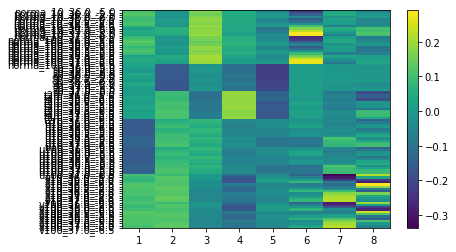

In [6]:
# Heatmap components 
fig, ax = plt.subplots(nrows=1, ncols=1)
components = model_pca.components_
plt.imshow(components.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(x_train.columns)), x_train.columns)
plt.xticks(range(8), np.arange(model_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

In [7]:
model_pca.explained_variance_ratio_

array([0.31142415, 0.22931761, 0.18513952, 0.11834928, 0.06400617,
       0.02065458, 0.01840515, 0.01203057])

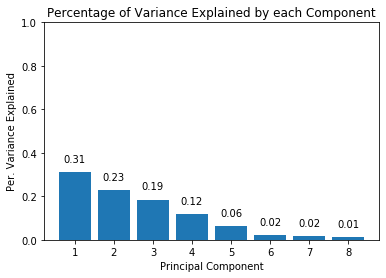

In [8]:
# plotting the explained variance by each component
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.bar(
    x      = np.arange(model_pca.n_components_) + 1,
    height = model_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(8) + 1, model_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model_pca.n_components_) + 1)
ax.set_ylim(0, 1)
ax.set_title('Percentage of Variance Explained by each Component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Per. Variance Explained');

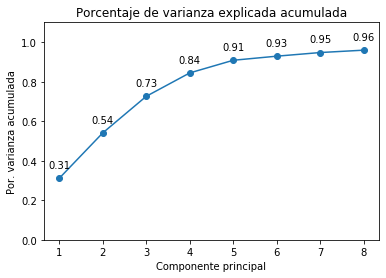

In [9]:
# plotting the cumulative expained variance
prop_varianza_acum = model_pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    np.arange(8) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(8) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(model_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');


In [36]:
principalComponents = pca_pipe.transform(x_train)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8'])

In [33]:
# new data matrix (training set) after dimension reduction
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
0,-4.092232,-10.466422,0.890484,-2.827543,-0.654417,2.206570,0.015582,-0.137476
1,-4.117281,-10.962177,1.697973,-2.578594,-0.215632,2.638705,0.103293,-0.185997
2,-2.661978,-11.380001,1.657733,-2.886959,0.027522,3.280241,0.003733,0.148682
3,1.160338,-10.402908,0.773144,-4.245895,-1.703168,2.340475,-1.074671,1.292175
4,5.416056,-7.385789,-0.275685,-4.616658,-4.212927,-0.355719,-1.448809,1.268680
...,...,...,...,...,...,...,...,...
8759,-3.897708,-2.708704,-1.141621,-5.573299,-3.521988,-1.008695,0.598985,-1.234211
8760,-4.240825,-1.366615,2.414171,-4.745471,-5.824887,-0.123679,0.731988,-0.971631
8761,-4.889649,-0.697338,4.989732,-3.703877,-6.291702,0.778272,1.635912,-1.199993
8762,-4.738737,-1.731329,5.247867,-3.956692,-6.735954,0.102615,1.342536,-0.840836


In [38]:
import seaborn as sns

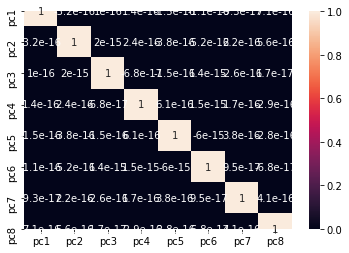

In [39]:
# not correlated at all after the transformation
corr = principalDf
Var_Corr = corr.corr()
corr_plot = sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

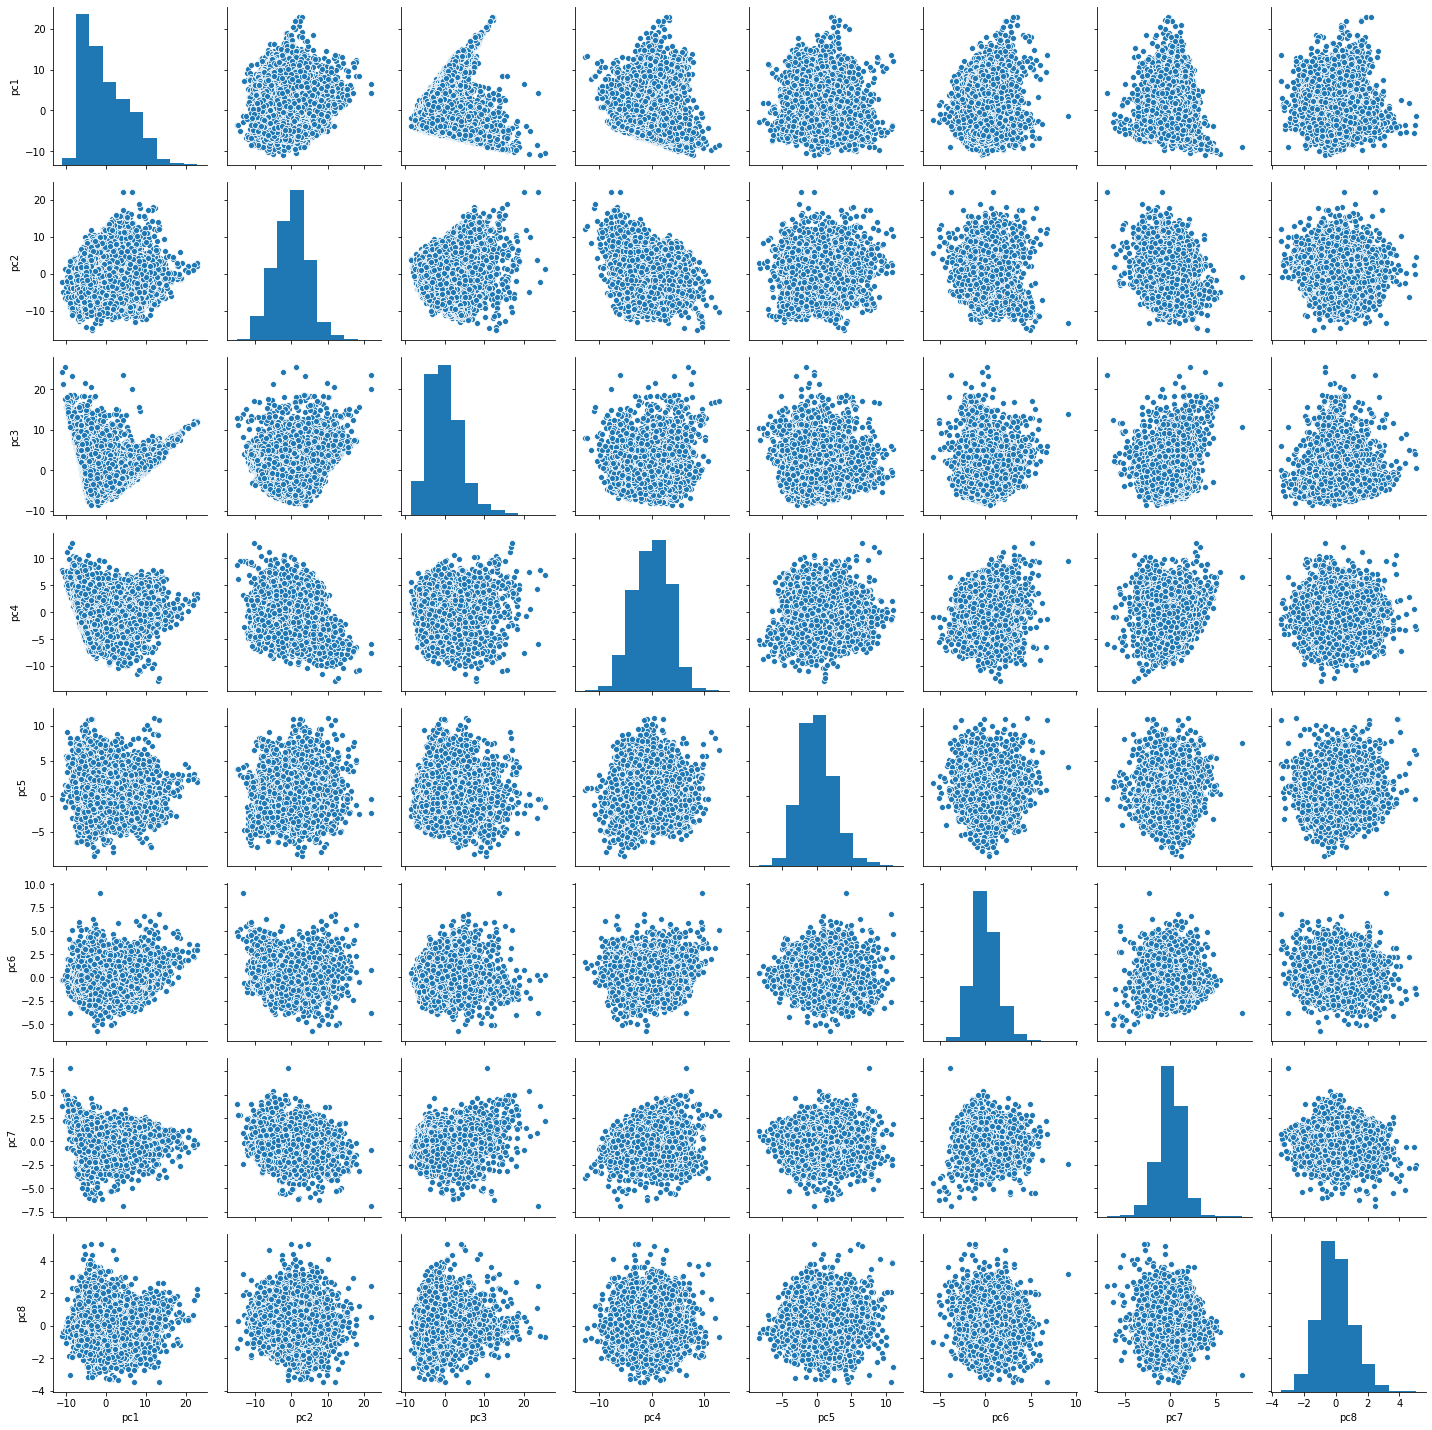

In [40]:
sns.pairplot(principalDf)
pairplot = plt.tight_layout()

In [42]:
principalDf['y']=y_train

In [43]:
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,y
0,-4.092232,-10.466422,0.890484,-2.827543,-0.654417,2.206570,0.015582,-0.137476,512.704
1,-4.117281,-10.962177,1.697973,-2.578594,-0.215632,2.638705,0.103293,-0.185997,571.841
2,-2.661978,-11.380001,1.657733,-2.886959,0.027522,3.280241,0.003733,0.148682,443.547
3,1.160338,-10.402908,0.773144,-4.245895,-1.703168,2.340475,-1.074671,1.292175,391.198
4,5.416056,-7.385789,-0.275685,-4.616658,-4.212927,-0.355719,-1.448809,1.268680,2201.885
...,...,...,...,...,...,...,...,...,...
8759,-3.897708,-2.708704,-1.141621,-5.573299,-3.521988,-1.008695,0.598985,-1.234211,256.879
8760,-4.240825,-1.366615,2.414171,-4.745471,-5.824887,-0.123679,0.731988,-0.971631,509.870
8761,-4.889649,-0.697338,4.989732,-3.703877,-6.291702,0.778272,1.635912,-1.199993,822.903
8762,-4.738737,-1.731329,5.247867,-3.956692,-6.735954,0.102615,1.342536,-0.840836,887.640


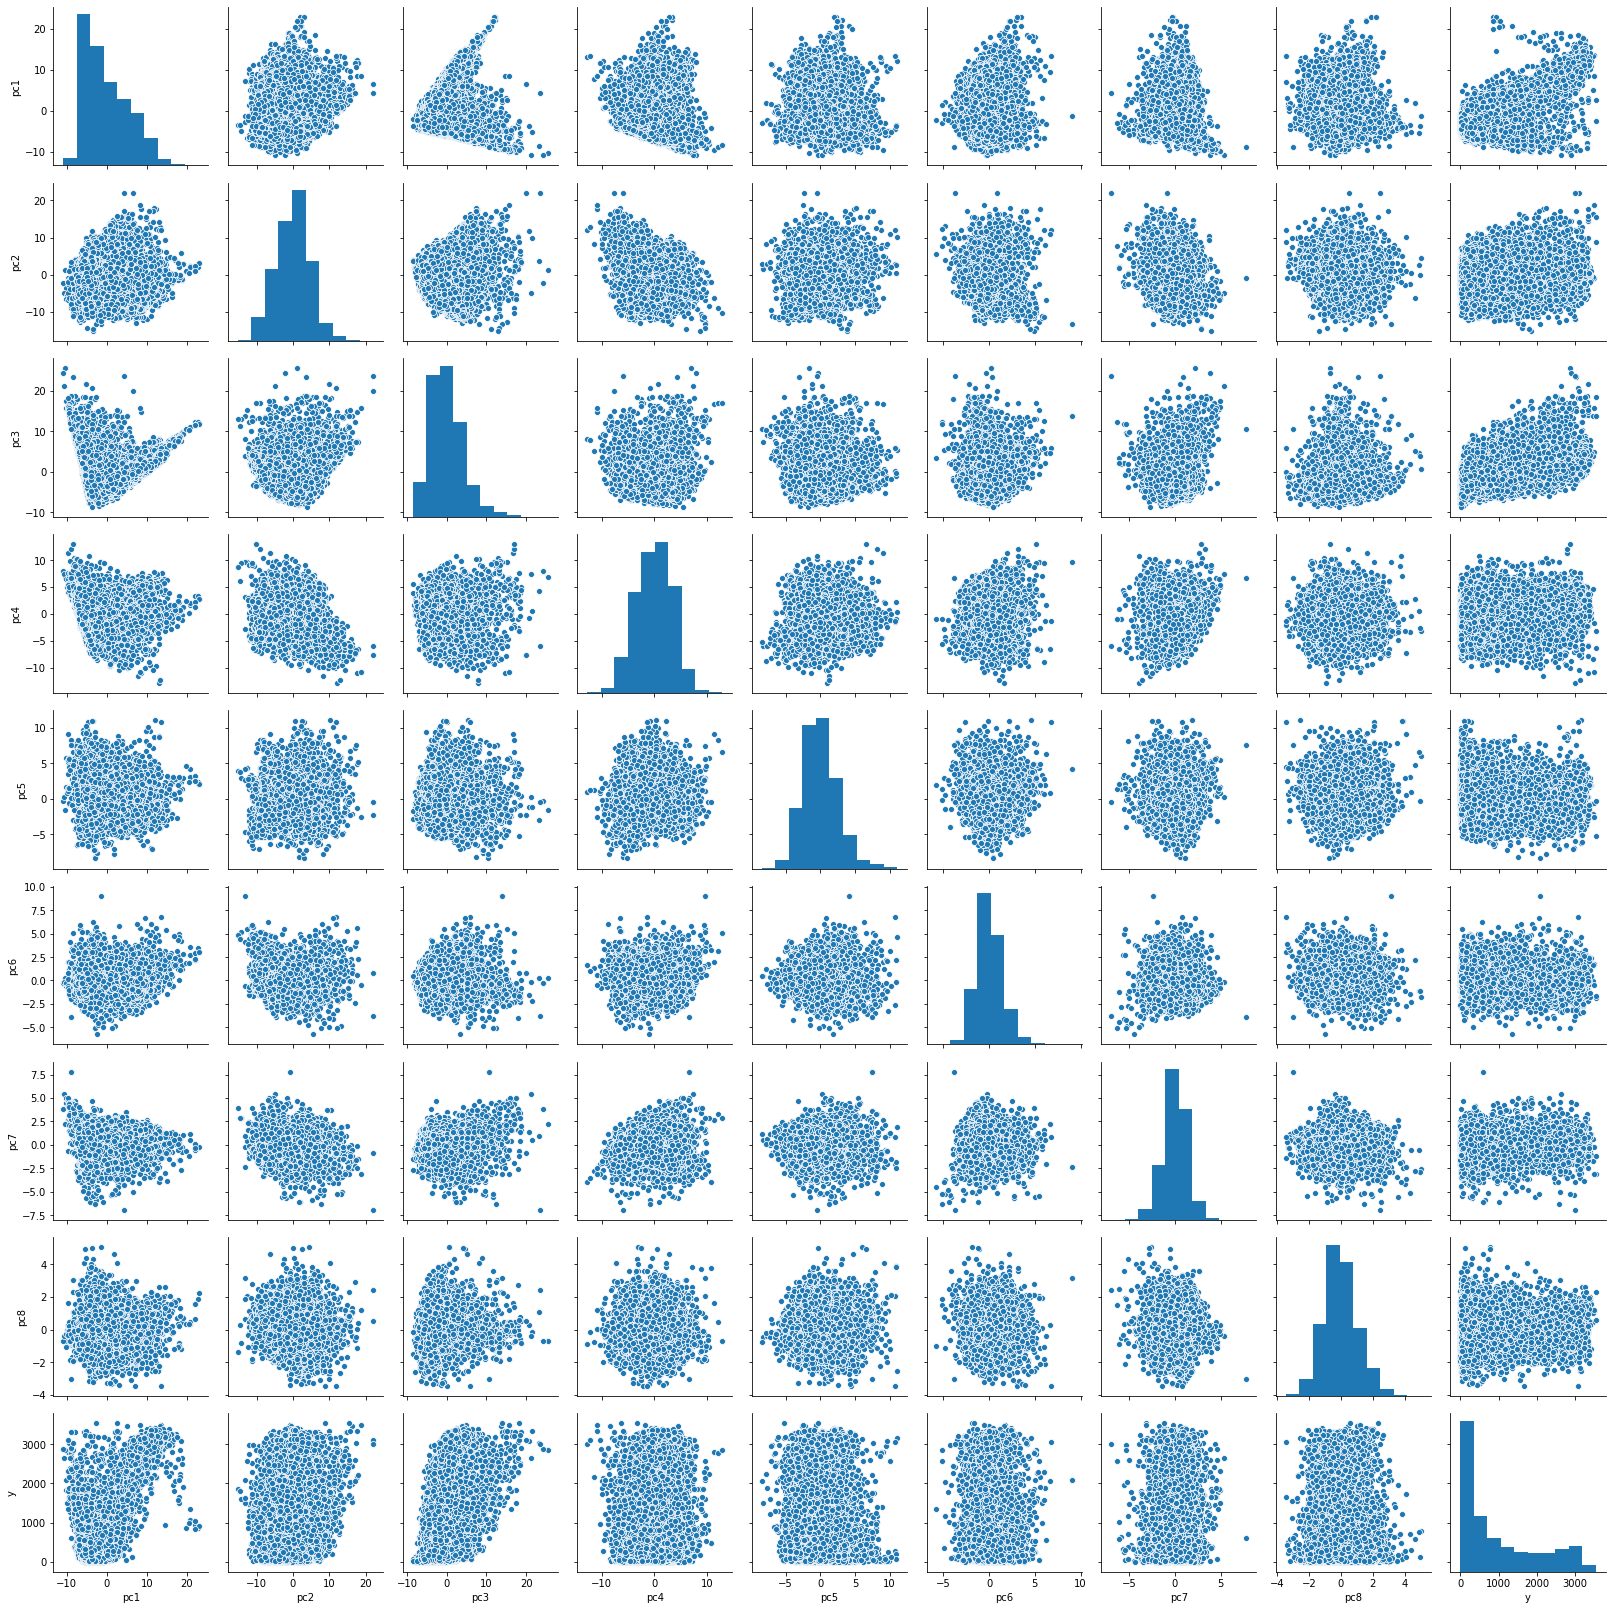

In [47]:
sns.pairplot(principalDf)
pairplot = plt.tight_layout()
plt.savefig('pairplot.png')